In [1]:
# Common imports
import sys
sys.path.append('../utils')
from common_imports import *
from process_data import *

# Set Environment
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["NCCL_P2P_DISABLE"] = "0"
os.environ["NCCL_IB_DISABLE"] = "0"
load_dotenv()
question_type_str = os.getenv("QUESTION_TYPE")
question_type = ast.literal_eval(question_type_str)
question_type_list = list(question_type.values()) 

# Config Data
SQUAD_PATH = '../../data/squad/train-v1.1_classified_qtype_prob.jsonl'
NEWS_PATH = '../../data/news/news_train_classified.json'
CNN_PATH = '../../data/cnn/cnn_train_classified.json'
DAILY_PATH = '../../data/daily/daily_train_classified.json'
HOTPOT_PATH = '../../data/hotpot/hotpot_train_classified.json'
SEARCH_PATH = '../../data/search/search_train_classified.json'

# Load Data
squad_data = open_jsonl(SQUAD_PATH)
news_data = open_json(NEWS_PATH)
cnn_data = open_json(CNN_PATH)
daily_data = open_json(DAILY_PATH)
hotpot_data = open_json(HOTPOT_PATH)
search_data = open_json(SEARCH_PATH)

# Config Model
model_dict = {'0': 'TinyLlama/TinyLlama-1.1B-Chat-v1.0',
              '1': 'microsoft/Phi-3-mini-4k-instruct',
              '2': 'meta-llama/Meta-Llama-3.1-8B-Instruct'}

# Select Model and Data
model_name = model_dict['1']  
train_data = squad_data
save_model_path = "../../model/gen_question/ft_genqa_1111_1111/"
inference_data = cnn_data
inference_model_path = "../../model/gen_question/ft_genqa_1111_1111/"

/home/gayeon39/miniconda3/envs/da/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-12 14:36:01.775004: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Skipping import of cpp extensions due to incompatible torch version 2.8.0+cu128 for torchao version 0.14.1             Please see https://github.com/pytorch/ao/issues/2919 for more info


### Train

In [ ]:
def format_train_prompt(sample):
    return f"""### Instruction:
    Generate a question based on the provided Context and Question Type.

    **Rules:**
    1.  The question must be a **single sentence**.
    2.  The question must match the intent of the **Question Type code**:
        * 0: Abbreviation
        * 1: Description
        * 2: Entity
        * 3: Human
        * 4: Location
        * 5: Numeric
        
    ### Example:
    - Context: "The Eiffel Tower is in Paris"
    - Question Type: 4
    - Generated Question: "Where is the Eiffel Tower located?"    

    ### Input:
    Context: {sample['context']}
    Question Type: {sample['q_type']}

    ### Response:
    {sample['question']}"""

In [ ]:
# Set up for train
# Set 4bit quantization  
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=False,
)
# Load Model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    use_cache=False # 학습 중에는 False로 설정
)
model.config.pretraining_tp = 1

# Load Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token # Set padding token
tokenizer.padding_side = "right" # Right padding recommended for fp16 training

# LoRA Config
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=32,                    # Rank 크기 (클수록 파라미터 많이 학습하지만 메모리 증가)
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"] # 튜닝할 모듈 지정
)

training_arguments = TrainingArguments(
    output_dir="../model/gen_question/checkpoint",
    num_train_epochs=3,           # 에포크 수 (데이터가 적으면 늘리세요)
    per_device_train_batch_size=2, # 배치 사이즈 (GPU 메모리에 맞춰 조절)
    gradient_accumulation_steps=4,
    optim="paged_adamw_32bit",
    save_steps=5000,
    logging_steps=1000,
    disable_tqdm=False,
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=True,                     # T4 GPU에서는 fp16 또는 bf16 사용
    bf16=False,
    max_grad_norm=0.3,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="constant",
    report_to="none"               # wandb 등 리포팅 끄기
)

trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    peft_config=peft_config,
    args=training_arguments,
    formatting_func=format_train_prompt, 
)

Truncating train dataset: 100%|██████████| 1483/1483 [00:00<00:00, 370048.95 examples/s]


In [ ]:
# Process Train Data
flat_data = parse_custom_data(train_data)
train_dataset = Dataset.from_list(flat_data)
print(f"Number of training samples: {len(train_dataset)}")

# Train Model
trainer.train()

# Save Trained Model
trainer.model.save_pretrained(save_model_path)
tokenizer.save_pretrained(save_model_path)

### Validation

/tmp/ipykernel_2197429/2603119886.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


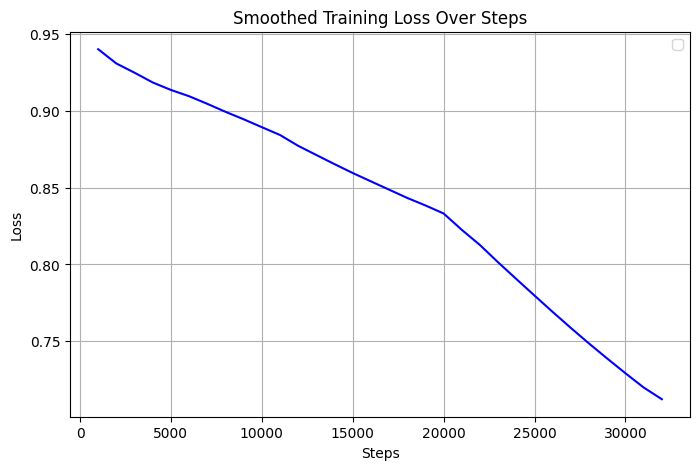

In [ ]:
# Train log history
log_history = trainer.state.log_history
df = pd.DataFrame(log_history)
plt.figure(figsize=(8, 5))

train_loss = df[df['loss'].notna()].copy()
window_size = 20 
train_loss['loss_smoothed'] = train_loss['loss'].rolling(window=window_size, min_periods=1).mean()
plt.plot(train_loss['step'], train_loss['loss_smoothed'], color='blue') 

max_step = train_loss['step'].max()
x_ticks = np.arange(0, max_step + 1, 5000)
plt.xticks(x_ticks)

plt.title("Smoothed Training Loss Over Steps")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

### Inference

In [ ]:
def format_inference_prompt(context, q_type):
    return f"""### Instruction:
    Generate a question based on the provided Context and Question Type.

    **Rules:**
    1.  The question must be a **single sentence**.
    2.  The question must match the intent of the **Question Type code**:
        * 0: Abbreviation
        * 1: Description
        * 2: Entity
        * 3: Human
        * 4: Location
        * 5: Numeric
        
    ### Input:
    Context: {context}
    Question Type: {q_type}

    ### Response:"""
    
def generate_question(data, output_path, question_type_li, pipe):
    gen_data = []
    for idx1, original_data in enumerate(tqdm(data, desc="Generating questions")): 
        title = original_data['title']
        modified_paragraph = copy.deepcopy(original_data['paragraphs'][0])
        context = modified_paragraph['context']
        original_qas_list = modified_paragraph['qas']
        
        final_qas_list = []
        
        for q in original_qas_list:
            final_qas_list.append({
                'id': q['id'],
                'q_type': q['q_type'],
                'question': q['question']
            })

        for q_type in question_type_li: 
            prompt = format_inference_prompt(context, q_type)
            gen = pipe(prompt, max_new_tokens=64, do_sample=True, top_p=0.9, temperature=0.8)
            gen_answer = gen[0]['generated_text'].split("### Response:")[-1].strip()
            
            random_id = str(uuid.uuid4()) 
            final_qas_list.append({
                "id": random_id,
                "q_type": q_type,
                "question": gen_answer
            })

        modified_paragraph['qas'] = final_qas_list
        gen_data.append({
            "title": title,
            "paragraphs": [modified_paragraph] 
        })
    
    # Save Data
    with io.open(output_path, 'w', encoding='utf-8') as f:
        for item in gen_data:
            json_line = json.dumps(item, ensure_ascii=False)
            f.write(json_line + '\n')
    print(f"데이터 {len(gen_data)}개를 '{output_path}'에 성공적으로 저장했습니다.")

In [ ]:
# Set up for inference
# Set 4bit quantization  
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=False,
)
# Load Model
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    use_cache=False # 학습 중에는 False로 설정
)
base_model.config.pretraining_tp = 1
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token # 패딩 토큰 설정
tokenizer.padding_side = "right" # fp16 학습 시 right padding 권장

# Load Trained LoRA Model
trained_model = PeftModel.from_pretrained(base_model, inference_model_path)
trained_model = trained_model.merge_and_unload()
trained_model.eval()
pipe = pipeline(task="text-generation", model=trained_model,tokenizer=tokenizer, max_new_tokens=64) 

Loading checkpoint shards: 100%|██████████| 2/2 [00:06<00:00,  3.10s/it]
Device set to use cuda:0


In [ ]:
# Debug Inference
sample = {'context':'The Eiffel Tower is located in Paris, France.',
          'q_type':4}
prompt = format_inference_prompt(sample['context'], sample['q_type'])
gen = pipe(prompt)
print('llm response:\n\n', gen[0]['generated_text'])
answer = gen[0]['generated_text'].split("### Response:")[-1].strip()
print('*'*50)
print('answer : ', answer)

In [18]:
# geneate questions
generate_question(cnn_data, '../../data/cnn/cnn_train_gen_question.jsonl', question_type_list, pipe)

Generating questions: 100%|██████████| 5/5 [00:12<00:00,  2.49s/it]

데이터 5개를 '../../data/cnn/cnn_train_gen_question.jsonl'에 성공적으로 저장했습니다.


In [20]:
generate_question(hotpot_data, '../../data/hotpot/hotpot_train_gen_question.jsonl', question_type_list, pipe)

Generating questions: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]

데이터 5개를 '../../data/hotpot/hotpot_train_gen_question.jsonl'에 성공적으로 저장했습니다.


In [23]:
gen_cnn = open_jsonl('../../data/cnn/cnn_train_gen_question.jsonl')